In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point

# Annan file prep
- ERSSTv5 for holocene SST
- HadISST.2 for holocene SIC

- Annan et al 2022 for LGM annual mean SST: seasonalize per LGMR
- LGMR for LGM monthly SIC

### Special Steps 
- Use 4xCO2 data to get a seasonal cycle, rebase to 2xCO2 annual mean
- Use piControl CCSM4-CAM4 to get a seasonal cycle, rebase to CESM1.0.4


### same old steps
- Apply anomalies to the Holocene data to create the LGM and 2xCO2 dataset
- Repeat the prep-cam-bc steps from atmos servers in this notebook, i.e.:
    - run the Hurrell adjustments to SST and ICEFRAC
- Then fudge the dataset into proper format for bcgen utility in this notebook
- Export the data, run bcgen
- Check data here

### Added ensemble member functionality

## Prep the Holocene dataset

In [2]:
## ERSST
pislice = slice('1851-01-01','1880-12-31')
path = '~/work/p2c2/lgm/annan/'
fname = 'ersst_v5.sst.mnmean.nc'
ersst = xr.open_dataset(path + fname).sel(time=pislice).groupby('time.month').mean()

## HadISST2
fname = 'HadISST.2.2.0.0_sea_ice_concentration.nc'
hadisst2 = xr.open_dataset(path + fname).sel(time=pislice).groupby('time.month').mean()

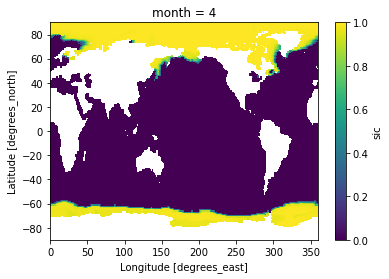

In [3]:
hadisst2.sic[3].plot()

In [4]:
## Regrid the ersst and hadisst data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = ersst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
ersst_regrid = regridder(ersst)

data_for_regridding = hadisst2
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
hadisst2_regrid = regridder(hadisst2)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


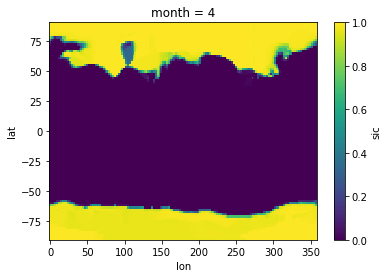

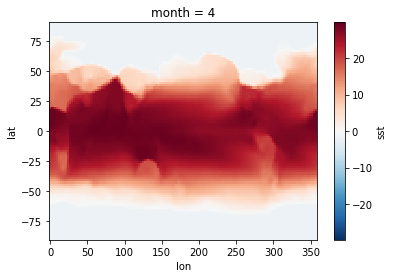

In [5]:
## these will become the holocene datasets
hadisst2_regrid.sic[3].plot()
plt.show()
ersst_regrid.sst[3].plot()
plt.show()

## Prep the LGM Annan dataset

In [6]:
## Annan
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'annan_lgm_SST_annual_merged_allens.nc'
annan_ens = xr.open_dataset(path + fname)
annan = annan_ens.mean(dim='nens')

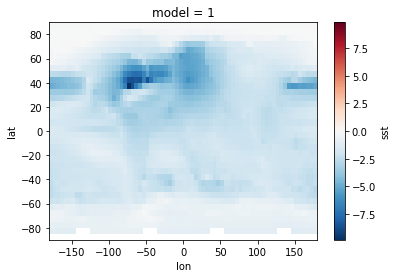

In [7]:
annan.sst.plot()

In [8]:
##  need to regrid annan SST onto 1.9x2.5
data_for_regridding = annan
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=16,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
annan_regrid = regridder(annan).drop('model')
annan_ens_regrid = regridder(annan_ens)#.drop('model')

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


#### Need LGMR data for seasonalizing and for sea ice concentration

In [9]:
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
LGMR_holo_infilled_sst = xr.open_dataset(path + 'LGMR_holo_SST_monthly_climo_merged.nc')
# LGMR_holo_infilled_sic = xr.open_dataset(path + 'LGMR_holo_SIC_monthly_climo_merged.nc')
LGMR_lgm_infilled_sst = xr.open_dataset(path + 'LGMR_lgm_SST_monthly_climo_merged.nc')
LGMR_lgm_infilled_sic = xr.open_dataset(path + 'LGMR_lgm_SIC_monthly_climo_merged.nc')

In [10]:
## also need to regrid LGMR SST onto 1.9x2.5
data_for_regridding = LGMR_lgm_infilled_sst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[-1]),1,0)
regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=16,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
LGMR_lgm_sst_regrid = regridder(data_for_regridding)
LGMR_holo_sst_regrid = regridder(LGMR_holo_infilled_sst)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


#### Seasonalize anomalies in Annan LGM SST

In [11]:
## get seasonal cycle from LGMR
## think it is better to inherit LGMR seasonal cycle since using its sea ice

LGMR_lgm_sst_rmmean = LGMR_lgm_sst_regrid.sst - LGMR_lgm_sst_regrid.sst.mean(dim='month')
LGMR_holo_sst_rmmean = LGMR_holo_sst_regrid.sst - LGMR_holo_sst_regrid.sst.mean(dim='month')
ersst_rmmean = ersst_regrid.sst - ersst_regrid.sst.mean(axis=0)

## two options: inherit LGMR seasonality or only inherit changes in seasonality from LGMR

## will inherit LGMR seasonal cycle when ersst is later added
seasonal_1 = (
    (LGMR_lgm_sst_rmmean - ersst_rmmean) + annan_regrid.sst.values) 
seasonal_1_ens = (
    LGMR_lgm_sst_rmmean.expand_dims('nens') - ersst_rmmean.expand_dims('nens') + np.moveaxis(
        np.tile(annan_ens_regrid.sst.values, [12,1,1,1]),1,0))

## will inherit ersst seasonal cycle (later) and changes in LGMR seasonal cycle between holo and LGM
seasonal_2 = (
    LGMR_lgm_sst_rmmean - LGMR_holo_sst_rmmean + annan_regrid.sst.values)
seasonal_2_ens = (
    LGMR_lgm_sst_rmmean.expand_dims('nens') - LGMR_holo_sst_rmmean.expand_dims('nens') + np.moveaxis(
        np.tile(annan_ens_regrid.sst.values, [12,1,1,1]),1,0))

## add annual mean to seasonal cycle
annan_seasonal = seasonal_1
annan_ens_seasonal = seasonal_1_ens

In [12]:
## got landfrac from the CLM input data namelist
path = '/home/disk/atmos/vcooper/work/ref/'
landfrac = xr.open_dataset(path + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

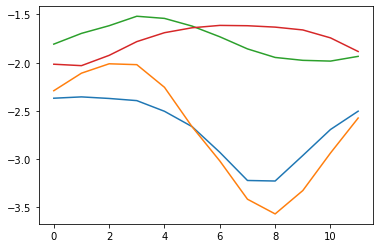

In [13]:
oarea = landfrac.area.where(landfrac.frac < 0.5).where(landfrac.yc > 0)
oarea = (oarea / oarea.sum()).values

plt.plot((seasonal_1*oarea).sum(axis=(1,2)))
plt.plot((seasonal_2*oarea).sum(axis=(1,2)))

oarea = landfrac.area.where(landfrac.frac < 0.5).where(landfrac.yc < 0)
oarea = (oarea / oarea.sum()).values

plt.plot((seasonal_1*oarea).sum(axis=(1,2)))
plt.plot((seasonal_2*oarea).sum(axis=(1,2)))

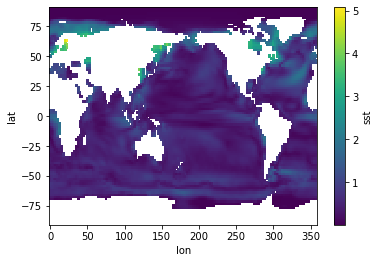

In [232]:
(seasonal_1 - seasonal_2).std(axis=0).where(landfrac.frac.values < 0.5).plot()

In [199]:
ihave = (LGMR_lgm_sst_regrid.sst - LGMR_holo_sst_regrid.sst).mean(axis=0)
ihave

<xarray.DataArray 'sst' (lat: 96, lon: 144)>
array([[-0.06280466, -0.06280466, -0.06280466, ..., -0.06292103,
        -0.06280466, -0.06280466],
       [-0.07152931, -0.07152607, -0.07152306, ..., -0.0715404 ,
        -0.07153648, -0.07153278],
       [-0.07056778, -0.07056279, -0.07055843, ..., -0.07144509,
        -0.0714373 , -0.07057343],
       ...,
       [-0.22149567, -0.22434673, -0.22721537, ..., -0.21127252,
        -0.21485149, -0.2185006 ],
       [-0.21307438, -0.21355837, -0.21402917, ..., -0.21153609,
        -0.21206484, -0.21256997],
       [-0.21010773, -0.21010773, -0.21010773, ..., -0.21010773,
        -0.21010773, -0.21010773]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

In [51]:
np.allclose((LGMR_lgm_sst_rmmean - LGMR_holo_sst_rmmean + ihave),(
    LGMR_lgm_sst_regrid.sst.values - LGMR_holo_sst_regrid.sst.values))

NameError: name 'ihave' is not defined

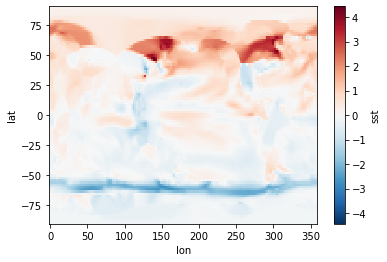

In [52]:
LGMRanom = LGMR_lgm_sst_regrid.sst - LGMR_holo_sst_regrid.sst
temp = LGMRanom - LGMRanom.mean(axis=0)
temp[0].plot()

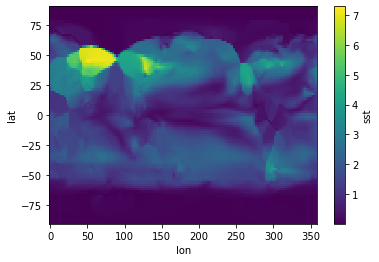

In [141]:
LGMR_lgm_sst_rmmean.std(dim='month').plot()

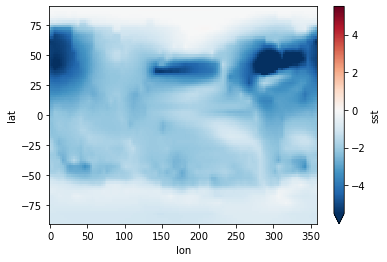

In [157]:
annan_regrid.sst.plot(cmap='RdBu_r',vmin=-5.5,vmax=5.5)

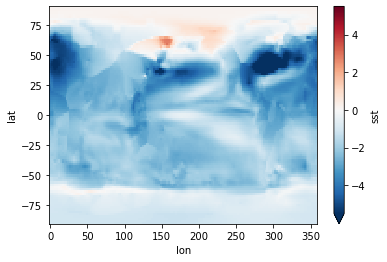

In [169]:
annan_seasonal[11].plot(cmap='RdBu_r',vmin=-5.5,vmax=5.5)

## Prep the 2xCO2 dataset

In [14]:
## final 20 years of SST data from abrupt4xCO2
# these files were prepped on cheyenne then sent here
# prep notebook is: 

path = '~/work/p2c2/lgm/ref_files/'
a4x_sst = xr.open_dataset(path + 'a4x_sst.nc')
a4x_sic = xr.open_dataset(path + 'a4x_sic.nc')

pic_sst = xr.open_dataset(path + 'pic_sst.nc')
pic_sic = xr.open_dataset(path + 'pic_sic.nc')

In [15]:
## load LongRunMIP data
## annual mean SST
nyears = 200
tslice = slice(2300,2300+nyears)
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/cesm104/'
fname = 'tos_ann_CESM104_abrupt2x_2500.nc'
cesm2x_sst = xr.open_dataset(
    lrmpath + fname, decode_times=False).isel(time=tslice).mean(dim='time')

fname = 'tos_ann_CESM104_control_1000.nc'
tslice = slice(800,800+nyears)
cesmctrl_sst = xr.open_dataset(
    lrmpath + fname, decode_times=False).isel(time=tslice).mean(dim='time')

In [16]:
%%time
## sea ice monthly
fname = 'sic_mon_CESM104_abrupt2x_2500.nc'
cesm2x_sic = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[-12*nyears:]
montharr = np.tile(np.arange(1,12+1,1),len(cesm2x_sic)//12)
cesm2x_sic = cesm2x_sic.assign_coords(
    month=('time',montharr)).groupby('month').mean()

fname = 'sic_mon_CESM104_control_1000.nc'
cesmctrl_sic = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[-12*nyears:]
montharr = np.tile(np.arange(1,12+1,1),len(cesmctrl_sic)//12)
cesmctrl_sic = cesmctrl_sic.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 26.9 s, sys: 945 ms, total: 27.8 s
Wall time: 27.8 s


### make longrunmip data monthly

In [17]:
## get seasonal cycle from ccs4m-cam4
a4x_sst_rmmean = a4x_sst - a4x_sst.mean(dim='month')

## add annual mean to seasonal cycle
cesm2x_sst_seasonal = a4x_sst_rmmean.sst + cesm2x_sst.tos.values

In [18]:
## repeat for preindustial
## get seasonal cycle from ccs4m-cam4
pic_sst_rmmean = pic_sst - pic_sst.mean(dim='month')

## add annual mean to seasonal cycle
cesmctrl_sst_seasonal = pic_sst_rmmean.sst + cesmctrl_sst.tos.values

In [19]:
## Regrid the a4x and pic data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = a4x_sst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[-1]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

a4x_sst_regrid = regridder(data_for_regridding)

## sic
data_for_regridding = a4x_sic
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[-1]),1,0)
a4x_sic_regrid = regridder(data_for_regridding)

## picontrol
data_for_regridding = pic_sst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[-1]),1,0)
pic_sst_regrid = regridder(data_for_regridding)

data_for_regridding = pic_sic
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[-1]),1,0)
pic_sic_regrid = regridder(data_for_regridding)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parame

In [20]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = cesmctrl_sst_seasonal.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

cesmctrl_sst_seasonal_regrid = regridder(cesmctrl_sst_seasonal)
cesm2x_sst_seasonal_regrid = regridder(cesm2x_sst_seasonal)
# cesmctrl_sic_regrid = regridder(cesmctrl_sic)
# cesm2x_sic_regrid = regridder(cesm2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


### load lgmDA Holocene data and apply anomalies

In [89]:
# ##### Load original data from U Arizona team for reference only #####

# ## Load Holocene output
# ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
# # dfile = 'lgmDA_hol_SST_monthly_climo.nc'
# dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
#                    tempds.set_coords(['lat','lon','month']).sst_std])
# holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

# ## includes antarctic ice sheet adjustments
# path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# holo_ice_merged = xr.open_dataset(path + 'lgmDA_hol_ICEFRAC_monthly_climo_merged_v2.nc')

# ## also load LGM to create Holofrank w LGM ice dataset
# ## load infilled version
# path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# # lgm_sst_merged = xr.open_dataset(path + 
# #                                      'lgmDA_lgm_SST_monthly_climo_merged.nc')

# lgm_ice_merged = xr.open_dataset(path + 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v3.nc').set_coords(['lat','lon'])

In [90]:
# ## also need to regrid holocene SST onto 1.9x2.5
# data_for_regridding = holo_sst_climo
# data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[-1]),1,0)
# regridder = xe.Regridder(data_for_regridding, newgrid,
#                          method='bilinear',
#                          periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=16,
#                          # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
#                          reuse_weights=False)
# holo_sst_regrid = regridder(data_for_regridding)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


### other option: load LGMR holocene data and apply anomalies

In [11]:
# path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# LGMR_holo_infilled_sst = xr.open_dataset(path + 'LGMR_holo_SST_monthly_climo_merged.nc')
# LGMR_holo_infilled_sic = xr.open_dataset(path + 'LGMR_holo_SIC_monthly_climo_merged.nc')

# LGMR_lgm_infilled_sic = xr.open_dataset(path + 'LGMR_lgm_SIC_monthly_climo_merged.nc')

In [12]:
# ## also need to regrid holocene SST onto 1.9x2.5
# data_for_regridding = LGMR_holo_infilled_sst
# data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[-1]),1,0)
# regridder = xe.Regridder(data_for_regridding, newgrid,
#                          method='bilinear',
#                          periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=16,
#                          # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
#                          reuse_weights=False)
# holo_sst_regrid = regridder(data_for_regridding)
# holo_ice_merged = LGMR_holo_infilled_sic
# lgm_ice_merged = LGMR_lgm_infilled_sic

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


### continue

In [60]:
## adjust basis of data
# cesm2x_sst_seasonal_regrid['sst'] = cesm2x_sst_seasonal_regrid.sst# - 273.15
cesm2x_sic = cesm2x_sic.rename('icefrac')

# cesmctrl_sst_seasonal_regrid['sst'] = cesmctrl_sst_seasonal_regrid.sst# - 273.15
cesmctrl_sic = cesmctrl_sic.rename('icefrac')

In [61]:
print('4x')
## check SST data
for i,val in enumerate(cesm2x_sst_seasonal_regrid):
    print(val.min().values, val.max().values)

## check ice data
for i,val in enumerate(cesm2x_sic):
    print(val.min().values, val.max().values)
    
print('\n piControl')
## check SST data
for i,val in enumerate(cesmctrl_sst_seasonal_regrid):
    print(val.min().values, val.max().values)

## check ice data
for i,val in enumerate(cesmctrl_sic):
    print(val.min().values, val.max().values)
    
print('\n holocene')
## check SST data
for i,val in enumerate(holo_sst_regrid.sst):
    print(val.min().values, val.max().values)

## check ice data
for i,val in enumerate(holo_ice_merged.icefrac):
    print(val.min().values, val.max().values)

4x
-4.076843670514429 31.975694842046803
-4.180029369671652 31.893398026800526
-4.282826220120904 32.2933122305882
-4.1849116902016945 32.44945354787553
-3.6295619996915347 31.831075396760035
-2.5837100641410062 31.99601158912062
-2.5896553228579986 32.256753111175925
-2.591735203505554 33.65280759375236
-2.5911348713440385 33.69825855732974
-2.5746797207000998 31.93563711440915
-2.866652846673435 31.748179350247717
-3.558621965587711 32.253152962728855
0.0 0.997098
0.0 0.9974937
0.0 0.99631935
0.0 0.9975692
0.0 0.9983935
0.0 0.9970143
0.0 0.99699503
0.0 0.9958622
0.0 0.9931046
0.0 0.99841154
0.0 0.99883413
0.0 0.9978872

 piControl
-3.5414364678166095 30.395444708740804
-3.7173299389581613 30.50807449035586
-3.853618424422521 30.450367603579323
-3.8161978432971675 30.456981846448755
-3.220767877925574 29.956694031546704
-2.734366080610855 30.041014963585514
-2.0996649054017444 30.057243924318733
-2.099039259059285 31.611722815170644
-2.096839368290504 31.266698066518
-2.09887609985090

NameError: name 'holo_sst_regrid' is not defined

In [21]:
## calculate anomalies relative to piControl
sst_anom_2x = cesm2x_sst_seasonal_regrid - cesmctrl_sst_seasonal_regrid
sic_anom_2x = cesm2x_sic - cesmctrl_sic

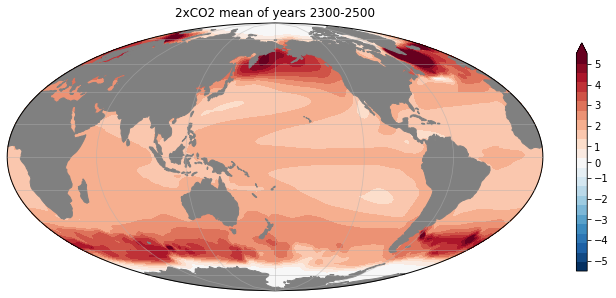

In [22]:
## checking the 2xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 5.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anom_2x.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('2xCO2 mean of years 2300-2500')
plt.show()

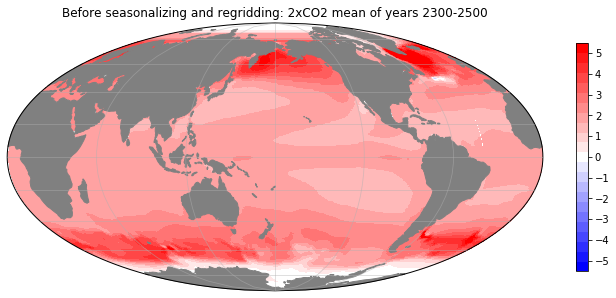

In [23]:
## checking the 2xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 5.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sst.tos - cesmctrl_sst.tos
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(a4x_sst.lon, a4x_sst.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#extend='max',#levels=levs,
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.set_global()
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Before seasonalizing and regridding: 2xCO2 mean of years 2300-2500')
plt.show()

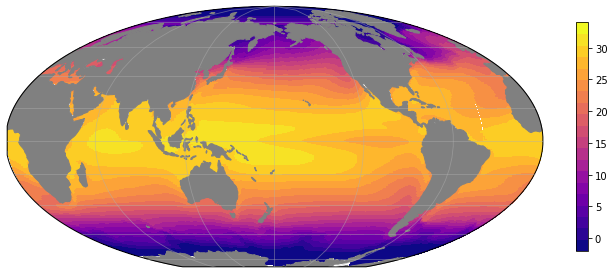

In [146]:
## checking the 4xCO2 climo pattern before regridding
fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sst.tos
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cmap=plt.cm.get_cmap('plasma', 20)
plt.pcolormesh(a4x_sst.lon, a4x_sst.lat, ds,
            cmap = cmap, vmin=-2,vmax=34,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

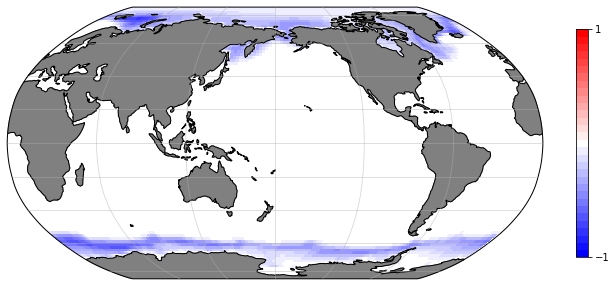

In [150]:
## checking the 4xCO2 anomaly pattern before regridding
nlevs = 8*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (cesm2x_sic - cesmctrl_sic).mean(axis=0)
# add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(a4x_sst_regrid.lon, a4x_sst_regrid.lat, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())


# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

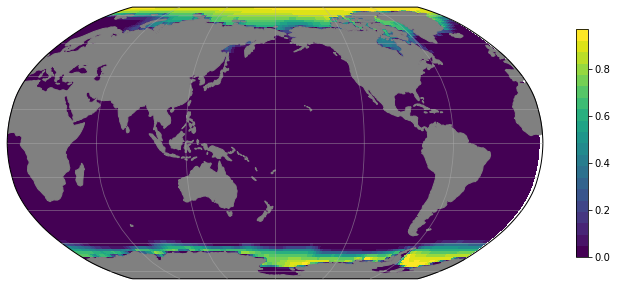

In [151]:
## checking the 4xCO2 anomaly pattern before regridding
cmap=plt.cm.get_cmap('viridis',20)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sic.mean(axis=0)
# add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(ds.lon, ds.lat, ds,
            cmap = cmap,
            transform=ccrs.PlateCarree())


plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('lgm prediddle: Month ' + str(isel_m+1))
plt.show()

# organize all 3 BC datasets for Annan

In [24]:
## Baseline holocene
holo_sst_climo = ersst_regrid.sst
holo_sic_climo = hadisst2_regrid.sic

## annan lgm
lgm_sst_climo = annan_seasonal + holo_sst_climo
lgm_sic_climo = LGMR_lgm_infilled_sic.icefrac ## using LGMR sea ice

lgm_sst_ens = annan_ens_seasonal + holo_sst_climo

## 2xCO2 CAM4
a2x_sst_climo = sst_anom_2x.values + holo_sst_climo
a2x_sic_climo = cesm2x_sic

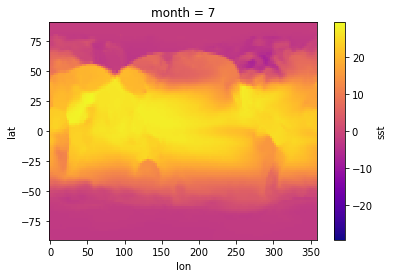

In [69]:
lgm_sst_climo[6].plot(cmap='plasma')

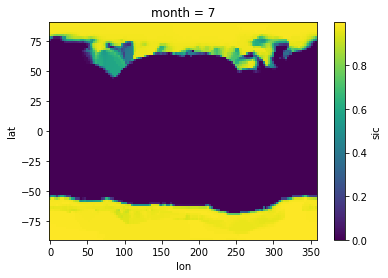

In [70]:
holo_sic_climo[6].plot(cmap='viridis')

## add piControl anomaly to holocene dataset

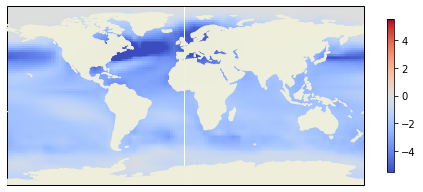

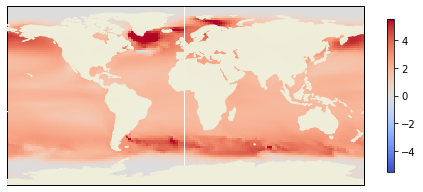

In [71]:
## spot check sst anomaly

im = 0
ds = lgm_sst_climo.mean(axis=0) - holo_sst_climo.mean(axis=0)

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

## spot check sst anomaly

im = 0
ds = a2x_sst_climo.mean(axis=0) - holo_sst_climo.mean(axis=0)

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

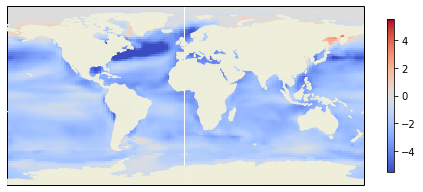

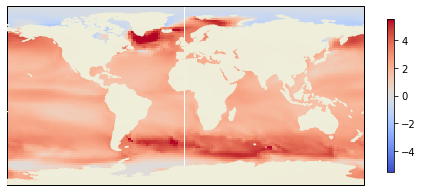

In [27]:
## spot check sst anomaly

im = 0
ds = lgm_sst_climo - holo_sst_climo#.mean(axis=0)
# ds = seasonal_1# - holo_sst_climo#.mean(axis=0)
ds = ds[im]

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

## spot check sst anomaly

im = 0
ds = a2x_sst_climo - holo_sst_climo#.mean(axis=0)
ds = ds[im]

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

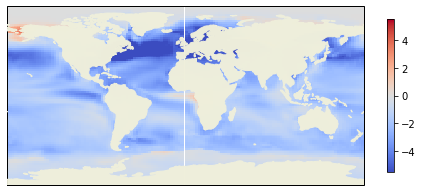

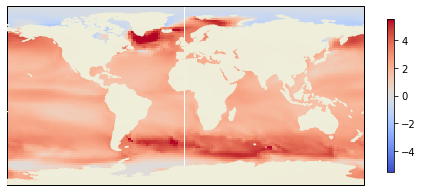

In [28]:
## spot check sst anomaly

im = 5
ds = lgm_sst_climo - holo_sst_climo#.mean(axis=0)
# ds = seasonal_1# - holo_sst_climo#.mean(axis=0)
ds = ds[im]

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

## spot check sst anomaly

im = 0
ds = a2x_sst_climo - holo_sst_climo#.mean(axis=0)
ds = ds[im]

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='coolwarm',vmin=-5.5,vmax=5.5,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

Need to make sure this weird ice anomaly goes away after Hurrell adj

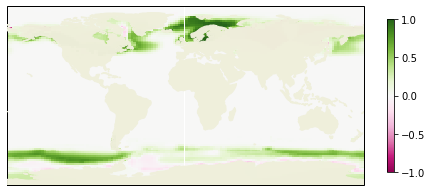

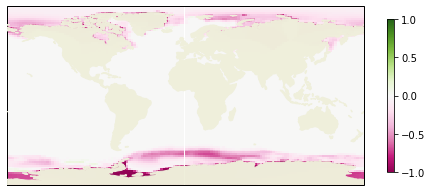

In [241]:
## spot check sic anomaly

ds = (lgm_sic_climo.values - holo_sic_climo).mean(axis=0)

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='PiYG',vmin=-1,vmax=1,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()


ds = (a2x_sic_climo.values - holo_sic_climo).mean(axis=0)

## regridded anomaly on AMIP grid
plt.figure(figsize=(8,4))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(ds.lon,ds.lat,
               ds,cmap='PiYG',vmin=-1,vmax=1,
               transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=5,alpha=0.99)
plt.colorbar(shrink=0.7)
plt.show()

### Hurrell adjustments

In [29]:
## baseline file to use as reference
## load modern day AMIP SSTs and SIC
## currently using the 1.9x2.5 version since that matches resolution of received icefrac data
path = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc',decode_times=False)
# amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc',decode_times=False)

In [30]:
## dummy code to preserve amip dataset attributes etc
holo_sst_bc_prediddle = holo_sst_climo.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
holo_ice_bc_prediddle = holo_sic_climo.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

lgm_sst_bc_prediddle = lgm_sst_climo.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
lgm_ice_bc_prediddle = lgm_sic_climo.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

a2x_sst_bc_prediddle = a2x_sst_climo.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
a2x_ice_bc_prediddle = a2x_sic_climo.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

lgm_sst_bc_prediddle_ens = amip2000.SST_cpl_prediddle.expand_dims(
    'nens') - amip2000.SST_cpl_prediddle.expand_dims('nens') + lgm_sst_ens.values

In [31]:
## Hurrell adjustments with sea ice prioritized as done originally

def data_consistency_before_bcgen_original(sst_prediddle_adj,sic_prediddle_adj):
    
    ## this function has the reference code from ncl script for each step
    
    # 1) If SST < -1.8 or ice frac >= 90%, SST = -1.8
    # SST = where(SST.le.-1.8, -1.8, SST)
    # SST = where(SEAICE.gt.90., -1.8, SST)

    sst_prediddle_adj = xr.where(sst_prediddle_adj < -1.8, 
                                        -1.8, sst_prediddle_adj)
    sst_prediddle_adj = xr.where(sic_prediddle_adj > 0.9, 
                                        -1.8, sst_prediddle_adj)

    # ; 2) min ice frac is 0%, max ice_frac is 100%
    # SEAICE = where(SEAICE.lt.0., 0., SEAICE)
    # SEAICE = where(SEAICE.gt.100., 100., SEAICE)
    sic_prediddle_adj = xr.where(sic_prediddle_adj < 0, 
                                        0, sic_prediddle_adj)
    sic_prediddle_adj = xr.where(sic_prediddle_adj > 1, 
                                        1, sic_prediddle_adj)


    # ; 3) Hurrell et al correction to SST (if 0.15 < ice frac < 0.9)
    # SST_max = 9.328*(0.729-(SEAICE/100.)^3)-1.8
    # SST = where((SEAICE.gt.15.).and.(SEAICE.lt.90.).and.(SST.gt.SST_max), SST_max, SST)
    SST_max = 9.328*(0.729-(sic_prediddle_adj)**3)-1.8
    sst_prediddle_adj = xr.where((sic_prediddle_adj > 0.15) & 
                                        (sic_prediddle_adj < 0.90) &
                                        (sst_prediddle_adj > SST_max), 
                                         SST_max, sst_prediddle_adj)    

    # ; 4) No sea ice if SST > 4.97
    # SEAICE = where(SST.gt.4.97, 0., SEAICE)
    sic_prediddle_adj = xr.where(sst_prediddle_adj > 4.97, 
                                        0, sic_prediddle_adj)
    
    # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
    # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
    # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
    ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
    sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) &  ## VTC switched to >=
                                        (sst_prediddle_adj < 4.97) & 
                                        (sic_prediddle_adj > ice_max), 
                                         ice_max, sic_prediddle_adj)


    # print((/"Filling in missing values in SST and SEAICE..."/))
    # poisson_grid_fill(SST, True, 1, 500, 0.01, 0.6, 0)
    # poisson_grid_fill(SEAICE, True, 1, 500, 0.01, 0.6, 0)
    ##  VTC: don't need this step because already extrapolated by regridding
    ##       but should check whether these land values are actually used?
    ##       appears they are not bc of land model.
    
    return(sst_prediddle_adj, sic_prediddle_adj)

In [32]:
## EXECUTE HURRELL
holo_sst_bc_prediddle_adj, holo_ice_bc_prediddle_adj = data_consistency_before_bcgen_original(
    holo_sst_bc_prediddle, holo_ice_bc_prediddle)

lgm_sst_bc_prediddle_adj, lgm_ice_bc_prediddle_adj = data_consistency_before_bcgen_original(
    lgm_sst_bc_prediddle,lgm_ice_bc_prediddle)

a2x_sst_bc_prediddle_adj, a2x_ice_bc_prediddle_adj = data_consistency_before_bcgen_original(
    a2x_sst_bc_prediddle, a2x_ice_bc_prediddle)

#### Ensemble members

In [33]:
lgm_sst_bc_prediddle_adj_ens, lgm_ice_bc_prediddle_adj_ens = data_consistency_before_bcgen_original(
    lgm_sst_bc_prediddle_ens,lgm_ice_bc_prediddle)

## holocene ice version
lgm_sst_bc_prediddle_adj_ensice, lgm_ice_bc_prediddle_adj_ensice = data_consistency_before_bcgen_original(
    lgm_sst_bc_prediddle_ens, holo_ice_bc_prediddle)

<xarray.DataArray 'sst' (time: 12, lat: 96, lon: 144, nens: 19)>
array([[[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         ...,
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

        [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         ...,
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

        [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         ...,
...
         ...,
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

        [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         ...,
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]],

        [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         ...,
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
         [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]]]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * time     (time) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
Dimensions without coordinates: nens

In [310]:
## in this prediddled version, the prediddle arrays will be equal to the ice_cov and SST_cpl arrays 
holo_bc_final_prediddle = amip2000.copy()

holo_bc_final_prediddle['ice_cov'] = holo_ice_bc_prediddle_adj.astype('float32')
holo_bc_final_prediddle['ice_cov_prediddle'] = holo_bc_final_prediddle.ice_cov

holo_bc_final_prediddle['SST_cpl'] = holo_sst_bc_prediddle_adj.astype('float32')
holo_bc_final_prediddle['SST_cpl_prediddle'] = holo_bc_final_prediddle.SST_cpl

###
lgm_bc_final_prediddle = amip2000.copy()

lgm_bc_final_prediddle['ice_cov'] = lgm_ice_bc_prediddle_adj.astype('float32')
lgm_bc_final_prediddle['ice_cov_prediddle'] = lgm_bc_final_prediddle.ice_cov

lgm_bc_final_prediddle['SST_cpl'] = lgm_sst_bc_prediddle_adj.astype('float32')
lgm_bc_final_prediddle['SST_cpl_prediddle'] = lgm_bc_final_prediddle.SST_cpl

###
a2x_bc_final_prediddle = amip2000.copy()

a2x_bc_final_prediddle['ice_cov'] = a2x_ice_bc_prediddle_adj.astype('float32')
a2x_bc_final_prediddle['ice_cov_prediddle'] = a2x_bc_final_prediddle.ice_cov

a2x_bc_final_prediddle['SST_cpl'] = a2x_sst_bc_prediddle_adj.astype('float32')
a2x_bc_final_prediddle['SST_cpl_prediddle'] = a2x_bc_final_prediddle.SST_cpl

## Save prediddled files

- to be ready for bcgen, a climatology needs to have an artificial dummy year before and after
- and it should only have "SST" and "ICEFRAC"
- I don't do this here-- i do it on Cheyenne after I send the file to:
- /glade/work/vcooper/p2c2/vtc_camsst/sstice_files


In [116]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan_holo_bc_final_prediddle.nc'
# holo_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [89]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan_holo_bc_final_prediddle.nc'
annan_holo_bc_final_prediddle = xr.open_dataset(savepath + fname)

In [312]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan_lgm_bc_final_prediddle.nc'
# lgm_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [90]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan_lgm_bc_final_prediddle.nc'
annan_lgm_bc_final_prediddle = xr.open_dataset(savepath + fname)

In [114]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan_ecs2x_bc_final_prediddle.nc'
# a2x_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [91]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan_ecs2x_bc_final_prediddle.nc'
annan_ecs2x_bc_final_prediddle = xr.open_dataset(savepath + fname)

#### Annan Ensemble members

In [87]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan_lgmens_bc_sst.nc'
# lgm_sst_bc_prediddle_adj_ens.rename('sst').to_netcdf(savepath + fname)

# fname = 'annan_lgmens-holoice_bc_sst.nc'
# lgm_sst_bc_prediddle_adj_ensice.rename('sst').to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [34]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan_lgmens_bc_sst.nc'
annan_lgmens_bc_final_prediddle = xr.open_dataset(savepath + fname)

In [36]:
# lgm_sst_bc_prediddle_adj_ens.rename('sst').to_netcdf('./tempAnnanEns.nc')

#### LGMR version

In [30]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'LGMR_ecs2x_bc_final_prediddle.nc'
# a2x_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [31]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'LGMR_ecs2x_bc_final_prediddle.nc'
LGMR_ecs2x_bc_final_prediddle = xr.open_dataset(savepath + fname)
LGM_bc_final_prediddle = LGMR_ecs2x_bc_final_prediddle

#### then send to: /glade/work/vcooper/p2c2/vtc_camsst/sstice_files/

### Check output

In [314]:
## LGMR
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'LGMRholo_bc_final_prediddle.nc'
LGMR_holo_bc_final_prediddle = xr.open_dataset(savepath + fname)

## lgmDA
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'holo_bc_final_prediddle_v2.nc'
lgmDAholo_bc_final_prediddle = xr.open_dataset(savepath + fname)

In [315]:
dsname = 'lgmDA'
dsname = 'LGMR'
dsname = 'Annan'

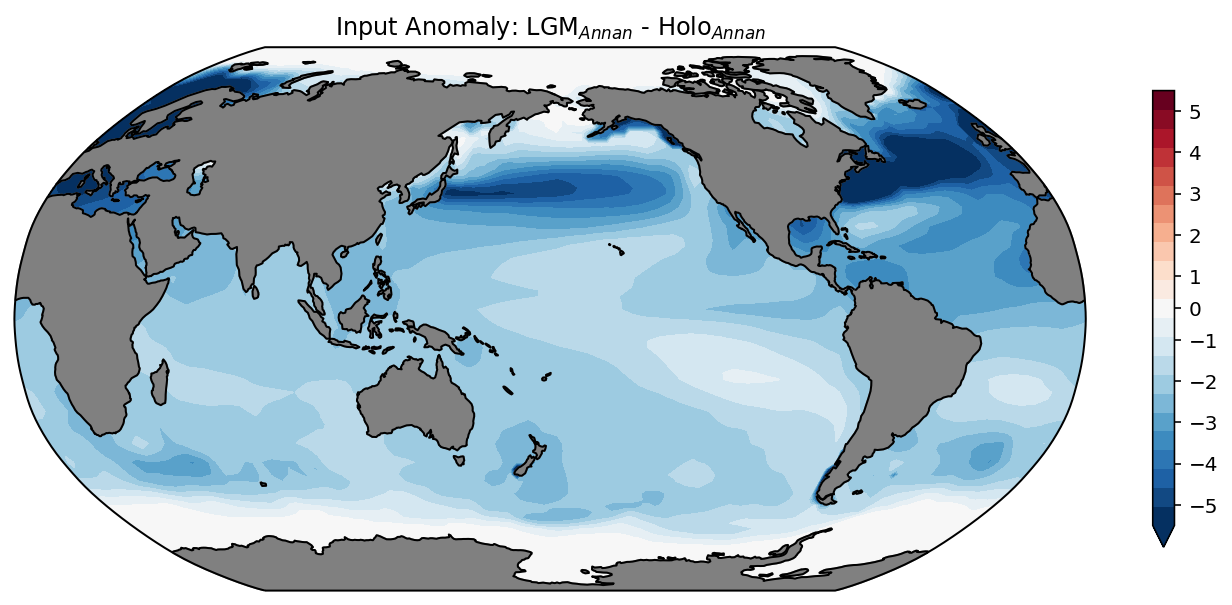

In [290]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 5.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_lgm_bc_final_prediddle.SST_cpl.mean(axis=0) - annan_holo_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input Anomaly: ' + 'LGM$_{b}$ - Holo$_{b}$'.format(
    a='{2x}',b='{'+dsname+'}'))
plt.show()

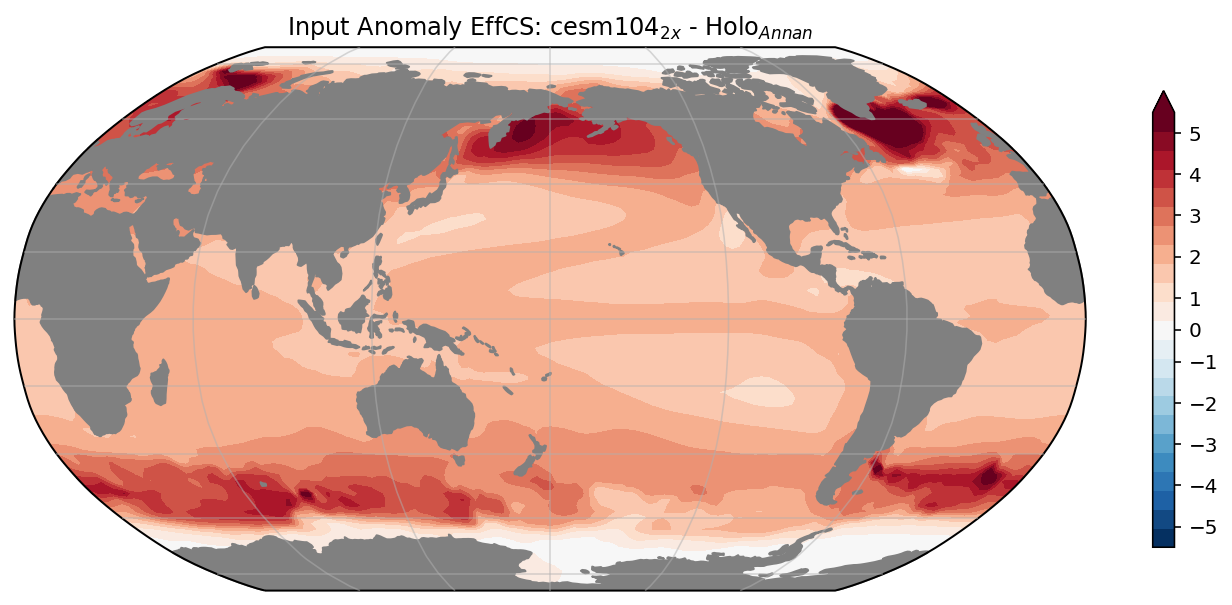

In [123]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 5.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ecs2x_bc_final_prediddle.SST_cpl.mean(axis=0) - annan_holo_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='max',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input Anomaly EffCS: ' + 'cesm104$_{a}$ - Holo$_{b}$'.format(
    a='{2x}',b='{'+dsname+'}'))
plt.show()

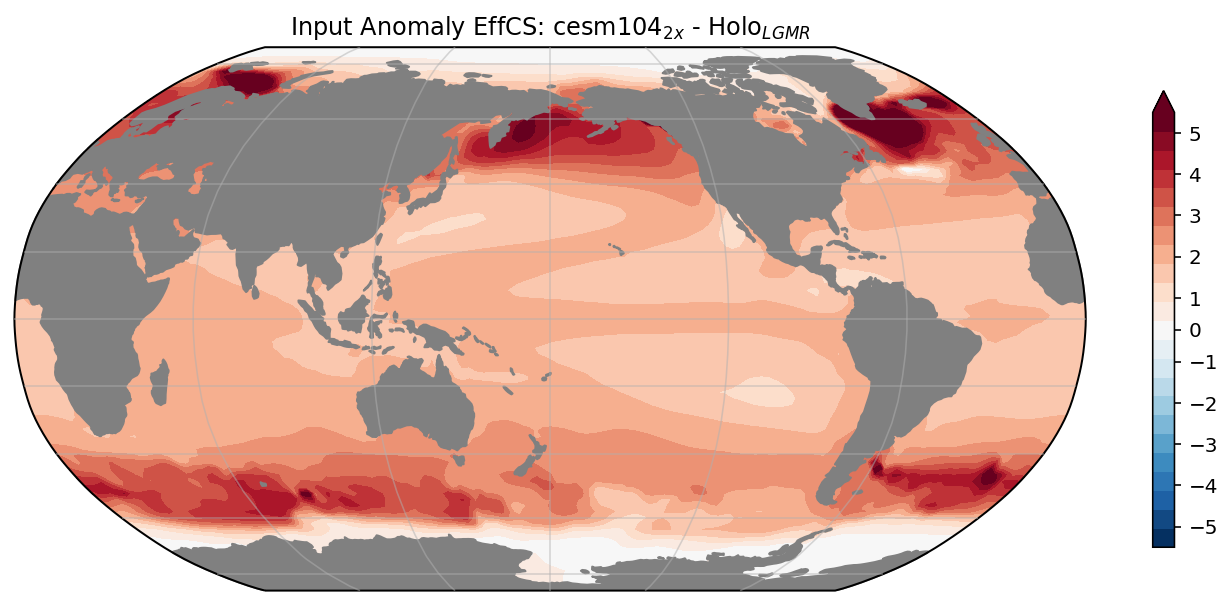

In [38]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 5.5
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

# ds = input_sst_regrid.mean(axis=0) - lgmDA_holo_original_sst_regrid.mean(axis=0)
ds = LGMR_ecs2x_bc_final_prediddle.SST_cpl.mean(axis=0) - LGMR_holo_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='max',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input Anomaly EffCS: ' + 'cesm104$_{a}$ - Holo$_{b}$'.format(
    a='{2x}',b='{'+dsname+'}'))
plt.show()

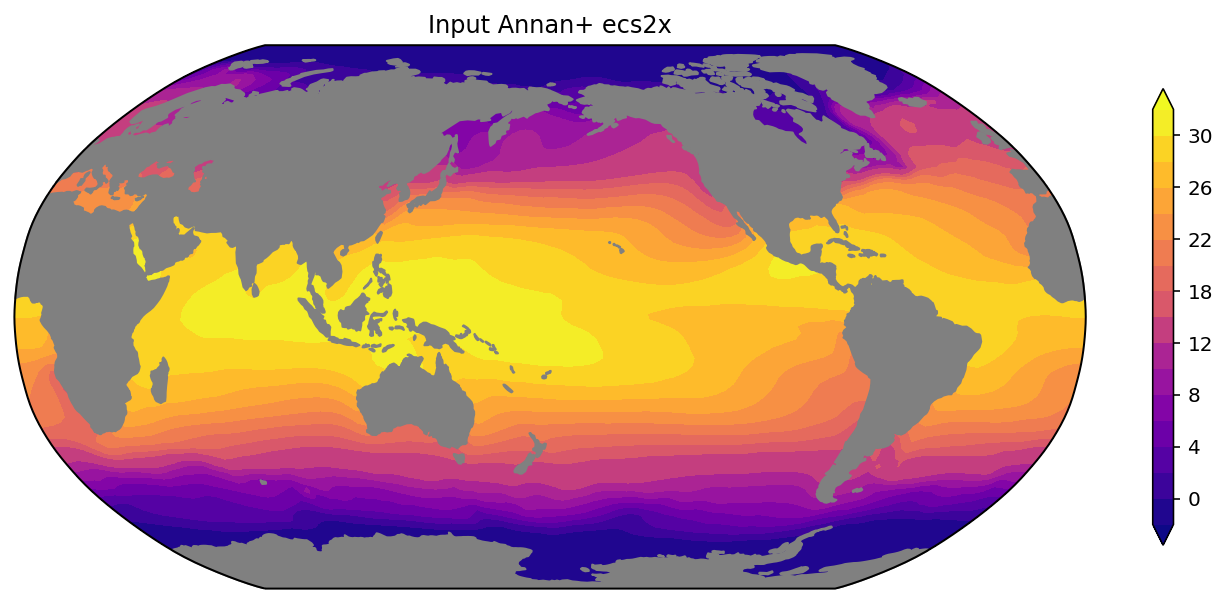

In [124]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ecs2x_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input ' + dsname + '+ ecs2x')
plt.show()

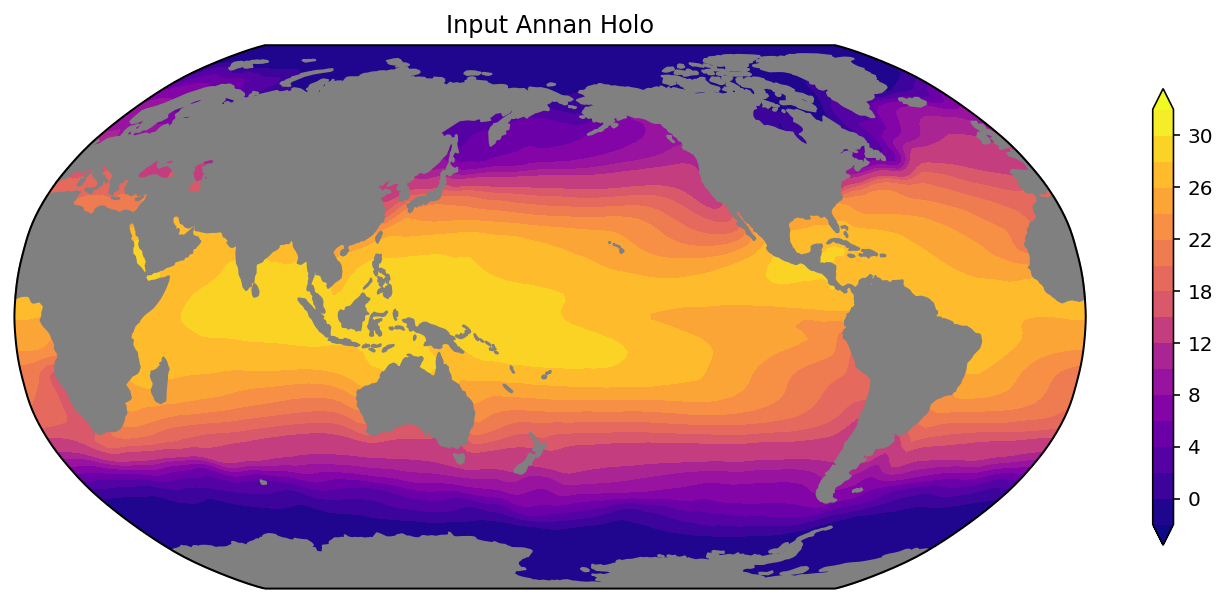

In [317]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_holo_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input ' + dsname + ' Holo')
plt.show()

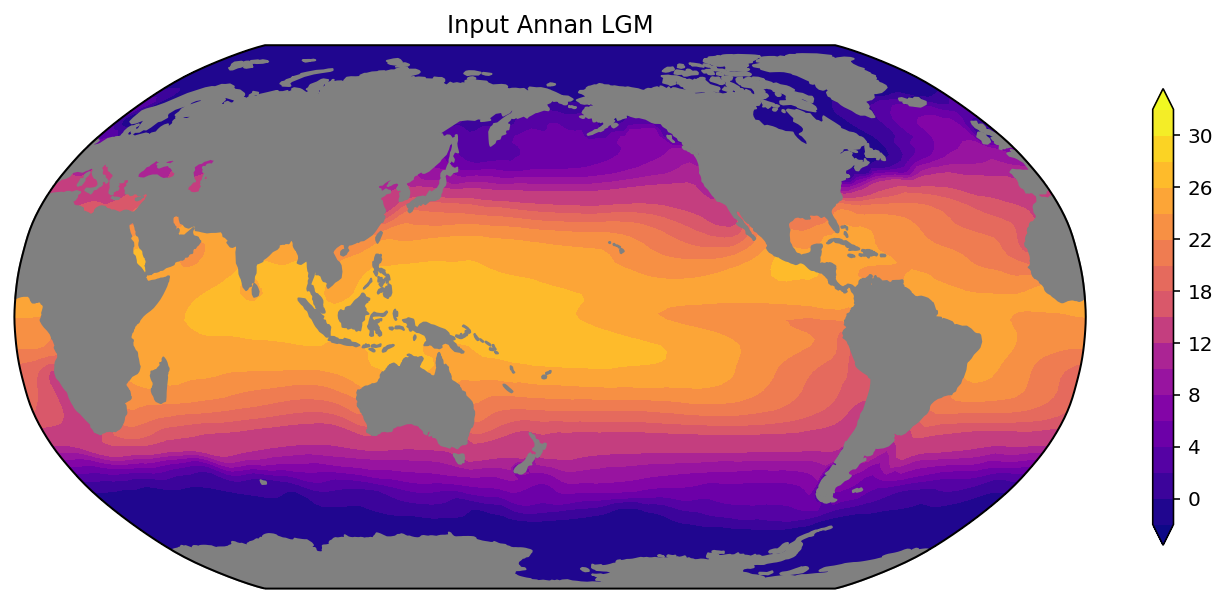

In [285]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_lgm_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input ' + dsname + ' LGM')
plt.show()

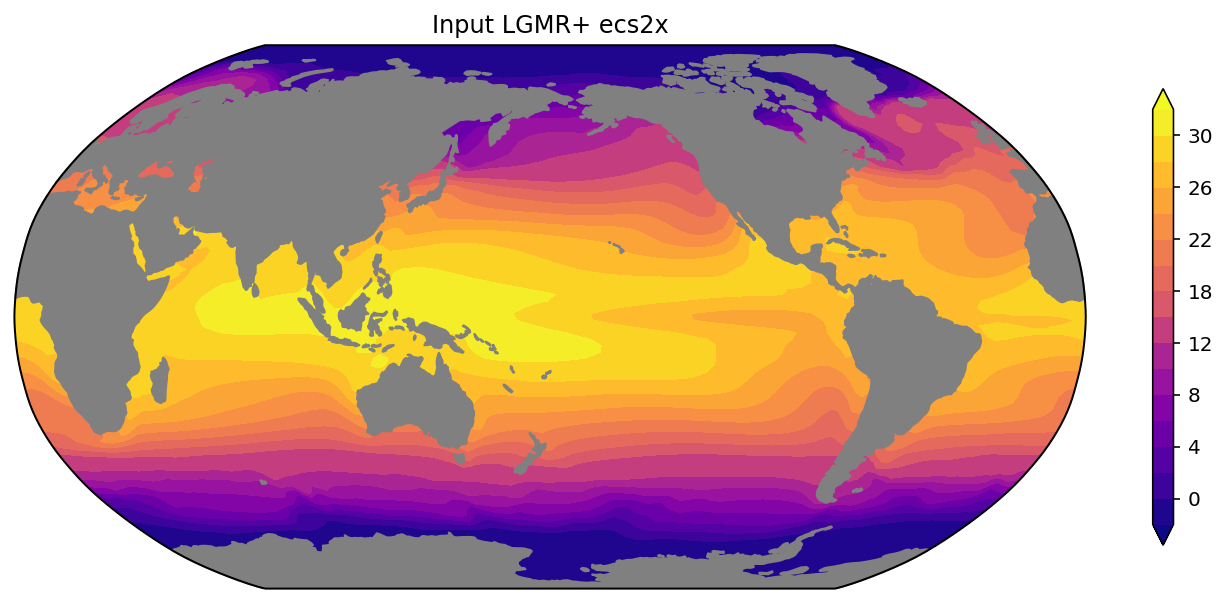

In [39]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_ecs2x_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Input ' + dsname + '+ ecs2x')
plt.show()

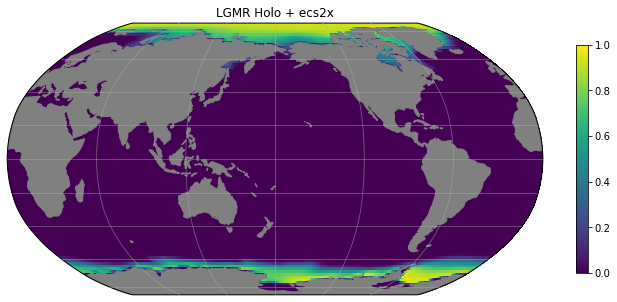

In [40]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_ecs2x_bc_final_prediddle.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " Holo + ecs2x")
plt.show()

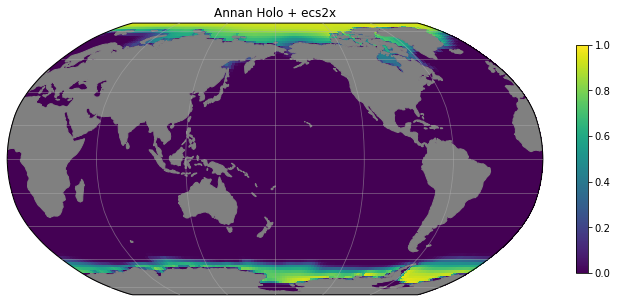

In [126]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_ecs2x_bc_final_prediddle.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " Holo + ecs2x")
plt.show()

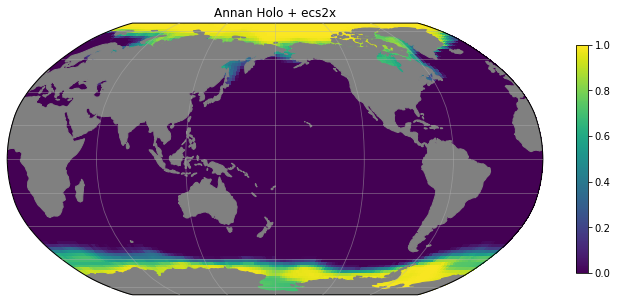

In [127]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_holo_bc_final_prediddle.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " Holo + ecs2x")
plt.show()

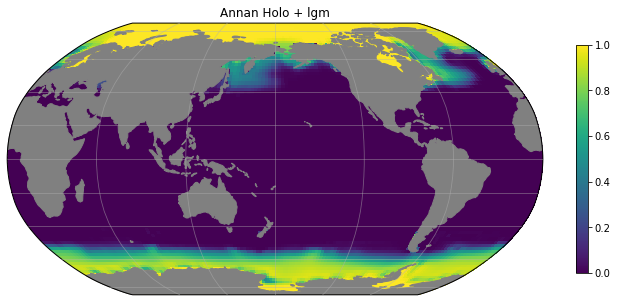

In [319]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_lgm_bc_final_prediddle.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " Holo + lgm")
plt.show()

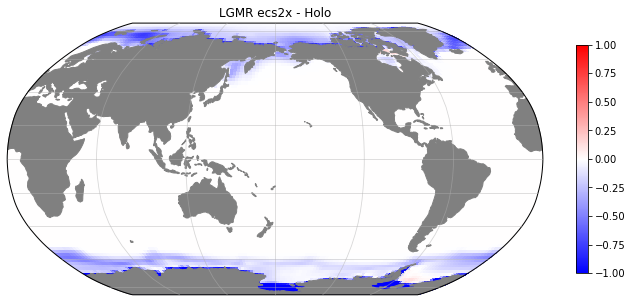

In [44]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (LGMR_ecs2x_bc_final_prediddle.ice_cov - LGMR_holo_bc_final_prediddle.ice_cov).mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'bwr', vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " ecs2x - Holo")
plt.show()

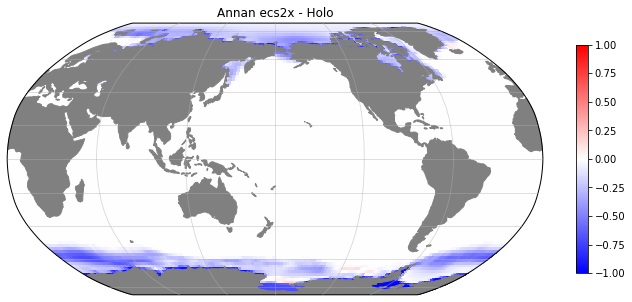

In [129]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (annan_ecs2x_bc_final_prediddle.ice_cov - annan_holo_bc_final_prediddle.ice_cov).mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'bwr', vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " ecs2x - Holo")
plt.show()

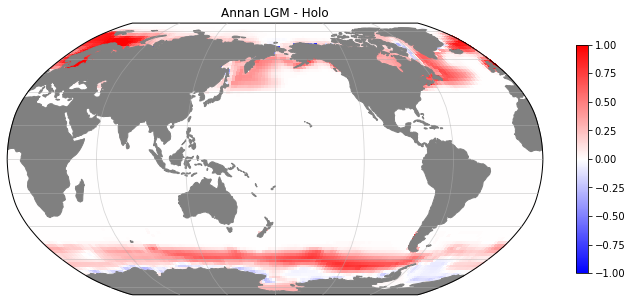

In [283]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (annan_lgm_bc_final_prediddle.ice_cov - annan_holo_bc_final_prediddle.ice_cov).mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'bwr', vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname + " LGM - Holo")
plt.show()